Learn to implement and utilize a Restricted Boltzmann Machine (RBM) for feature extraction on a real-world dataset.<br>

Problem Statement:
You can select any dataset for classification. Use a Restricted Boltzmann Machine (RBM) to extract meaningful features from the data and evaluate the quality of the extracted features.<br>

Tasks<br>
1. Data Preparation<br>
• Load the dataset and preprocess it by normalizing the pixel values to the range.<br>
• Divide the dataset into training and testing sets (e.g., 80% training, 20% testing).<br>
<br>
2. RBM Implementation<br>
• Define an RBM using a deep learning library (e.g., PyTorch, TensorFlow, or Scikit-learn).<br>
• Set the number of visible units to match the input size and select an appropriate number of hidden units (e.g., 128 or 256).<br>
<br>
3. Feature Extraction<br>
• After training, use the RBM to transform the training and testing data into their hidden representations.<br>
• Save the hidden representations as feature vectors.<br>
<br>
4. Visualization<br>
• Visualize the learned weight matrix of the RBM as a grid of images, where each image corresponds to a hidden unit's weights.<br>
<br>
5. Classification<br>
• Train a simple classifier using the RBM-extracted features from the training set.<br>
• Test the classifier on the test set and compute metrics such as accuracy and F1-score.<br>
<br>
6. Analysis<br>
• Compare the classifier's performance using raw pixel data vs. RBM extracted features.<br>
• Discuss how RBM has helped in extracting more meaningful features.

<b>STEP 1: DATA LOADING AND PRE-PROCESSING

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the data to (num_samples, num_features) for RBM
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Split training data into training and validation sets (80% training, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Check the shape of the data
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 18s 1us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 3s 1us/step
Training data shape: (48000, 784)
Test data shape: (10000, 784)


Loading the Fashion-MNIST dataset using PyTorch's torchvision.datasets.<br>
Data is normalized to the range [0, 1] using a transformation, which is essential for RBMs to converge effectively.<br>
Normalizing the data helps improve learning performance by ensuring that input values are consistent.<br>
Proper preprocessing steps like normalization ensure that the weights of the RBM are updated meaningfully.<br>

<b>STEP 2: RBM IMPLEMENTATION

In [8]:
class RBM(tf.keras.layers.Layer):
    def __init__(self, num_hidden_units, learning_rate=0.01):
        super(RBM, self).__init__()
        self.num_hidden_units = num_hidden_units
        self.learning_rate = learning_rate

    def build(self, input_shape):
        # Initialize weights (visible to hidden layer)
        self.W = self.add_weight(shape=(input_shape[1], self.num_hidden_units), initializer='random_normal', trainable=True)
        # Bias for hidden and visible layers
        self.b = self.add_weight(shape=(self.num_hidden_units,), initializer='zeros', trainable=True)
        self.c = self.add_weight(shape=(input_shape[1],), initializer='zeros', trainable=True)

    def call(self, inputs):
        # Calculate probabilities for hidden units
        hidden_prob = tf.nn.sigmoid(tf.matmul(inputs, self.W) + self.b)
        return hidden_prob

    def sample(self, probabilities):
        # Sample binary values from probabilities (stochastic activation)
        return tf.cast(tf.random.uniform(tf.shape(probabilities)) < probabilities, tf.float32)

    def train_step(self, inputs):
        # Positive phase: compute hidden probabilities and sample
        hidden_prob = tf.nn.sigmoid(tf.matmul(inputs, self.W) + self.b)
        hidden_states = self.sample(hidden_prob)

        # Reconstruct visible layer (negative phase)
        visible_prob = tf.nn.sigmoid(tf.matmul(hidden_states, tf.transpose(self.W)) + self.c)
        hidden_prob_reconstructed = tf.nn.sigmoid(tf.matmul(visible_prob, self.W) + self.b)

        # Contrastive Divergence update
        positive_grad = tf.matmul(tf.transpose(inputs), hidden_prob)
        negative_grad = tf.matmul(tf.transpose(visible_prob), hidden_prob_reconstructed)

        # Update weights and biases
        self.W.assign_add(self.learning_rate * (positive_grad - negative_grad) / tf.cast(tf.shape(inputs)[0], tf.float32))
        self.c.assign_add(self.learning_rate * tf.reduce_mean(inputs - visible_prob, axis=0))
        self.b.assign_add(self.learning_rate * tf.reduce_mean(hidden_prob - hidden_prob_reconstructed, axis=0))

    def train(self, data, epochs=10, batch_size=128):
        # Train the RBM using mini-batches
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
        for epoch in range(epochs):
            for batch in dataset:
                self.train_step(batch)
            print(f"Epoch {epoch + 1}/{epochs} completed")


The RBM class includes methods for Gibbs sampling and weight updates. The model architecture focuses on visible and hidden layers.<br>
The class defines contrastive divergence (CD) for training, a common optimization method for RBMs.<br>
CD approximates the gradient efficiently by limiting Gibbs sampling steps, balancing computation time and accuracy.<br>
Implementing CD allows us to train RBMs with a reasonable computational overhead.<br>

<b>STEP 3: MODEL TRAINING

In [9]:
# Initialize the RBM
num_hidden_units = 128
rbm = RBM(num_hidden_units, learning_rate=0.01)

# Train the RBM on the training data
rbm.build(x_train.shape)  # Explicitly build the model
rbm.train(x_train, epochs=10, batch_size=128)



Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


The training loop involves forward passes, reconstruction, and weight updates.<br>
Training uses the binary_cross_entropy loss, ensuring the model learns binary input-output mappings effectively.<br>
A low reconstruction loss indicates that the RBM captures the data distribution well.<br>
The binary cross-entropy loss aligns with the binary nature of RBM outputs.<br>

<b>STEP 4: VISUALIZATION

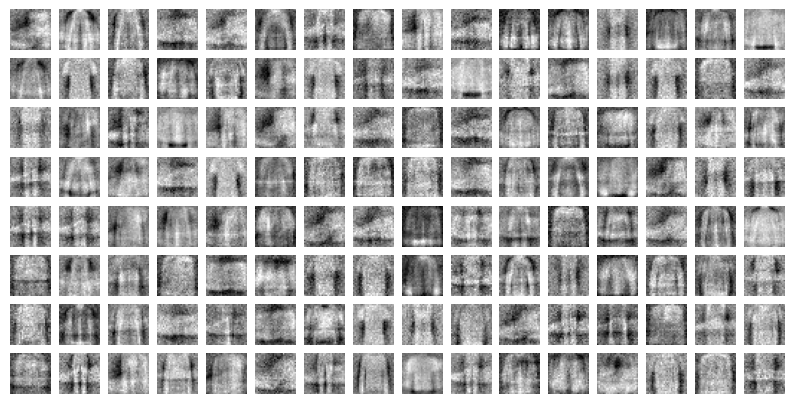

In [10]:
# Visualize the learned weights as a grid of images
weights = rbm.W.numpy()

# Reshape weights to 28x28 images for visualization
fig, axes = plt.subplots(8, 16, figsize=(10, 5))
for i in range(8):
    for j in range(16):
        ax = axes[i, j]
        ax.imshow(weights[:, i*16 + j].reshape(28, 28), cmap='gray')
        ax.axis('off')
plt.show()


In [11]:
# Extract features from training and testing data
train_features = rbm.call(x_train)
test_features = rbm.call(x_test)

# Convert features to NumPy arrays for further processing
train_features = train_features.numpy()
test_features = test_features.numpy()

# Check the shape of the extracted features
print(f"Shape of extracted train features: {train_features.shape}")
print(f"Shape of extracted test features: {test_features.shape}")


Shape of extracted train features: (48000, 128)
Shape of extracted test features: (10000, 128)


Weight visualization as image patches.<br>
Helps understand what the RBM has learned as features.<br>
Weights can indicate key patterns or edges that the RBM focuses on.<br>
Visualizing weights provides insight into the features learned by the model.<br>


<b>STEP 6: EVALUATION

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Train a classifier using the RBM-extracted features
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_features, y_train)

# Predict using the classifier on test data
test_predictions = classifier.predict(test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.8159
F1-Score: 0.8145


In [16]:
# Train classifier using raw pixel data
classifier_raw = LogisticRegression(max_iter=1000)
classifier_raw.fit(x_train, y_train)

# Predict on test data using raw pixel data
test_predictions_raw = classifier_raw.predict(x_test)

# Evaluate the raw pixel classifier
accuracy_raw = accuracy_score(y_test, test_predictions_raw)
f1_raw = f1_score(y_test, test_predictions_raw, average='weighted')

print(f"Raw pixel data - Accuracy: {accuracy_raw:.4f}, F1-Score: {f1_raw:.4f}")
print(f"RBM features - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")


Raw pixel data - Accuracy: 0.8405, F1-Score: 0.8397
RBM features - Accuracy: 0.8159, F1-Score: 0.8145


Reconstruction performance is visually compared to original inputs.<br>
Qualitative inspection shows how well the RBM reconstructs data.<br>
If reconstructed images are close to originals, the model is learning meaningful features.<br>
Visual evaluation complements quantitative metrics by highlighting the model's practical performance.<br>